In [29]:
from pathlib import Path
import pygimli as pg  # Stelle sicher, dass das Modul pg importiert ist und verfügbar ist
from pygimli.physics import ert
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
import os
import numpy as np

from Hilfsfunktionen import T_corr_nach_Inversion
from Hilfsfunktionen import plotting_function
from Hilfsfunktionen import plotting_function_FTL

# Read data
file = "two_timesteps.ohm"
base_dir = Path("filtered_data")
data = []
for unterordner in base_dir.iterdir():
    if unterordner.is_dir():
        datei_pfad = unterordner / "two_timesteps.ohm" 
        if datei_pfad.exists():
            daten_objekt = pg.load(str(datei_pfad))
            data.append([unterordner.name, daten_objekt])
            print(f"Load data: {datei_pfad}")

# Create method manager
manager = []
for ts in data:
    manager.append(ert.ERTManager(ts[1], verbose=True))

# Create mesh
mesh = manager[0].createMesh(quality = 34, paraMaxCellSize=0.5, paraDepth=15)
manager[0].invert(quality = 34, paraMaxCellSize=0.5, maxIter=1 ,dPhi= 0.1, paraDepth=15,lam=20)

# Inversion without temperature correction
DATA = [dat[1] for dat in data]
# Full time-lapse
scalef = 0.7
fop = pg.frameworks.MultiFrameModelling(ert.ERTModelling, scalef=scalef)
fop.setData(DATA)
#manager[0].createMesh(quality=34,paraMaxCellSize=20)
fop.setMesh(mesh)
print(fop.mesh())  # important to call mesh() function once!
dataVec = np.concatenate([data["rhoa"] for data in DATA])
errorVec = np.concatenate([data["err"] for data in DATA])
startModel = fop.createStartModel(dataVec)
inv = pg.Inversion(fop=fop, startModel=startModel, verbose=True)
model = inv.run(dataVec, errorVec, maxIter=10, lam= 20, startModel=startModel, verbose=True)
chi2_oT = []
chi2_oT.append(round(inv.chi2(),2))
mod = np.reshape(model, [len(DATA), -1])

# PLot
#plotting_function_FTL(data,manager = manager, results = mod, folder_name= 'FTL', filename= 'Two_timesteps_without_Tcorr', chi2=chi2_oT, scalef=scalef, rrms=rrms)

# Temperature correction    
mod_corr = [] 
temp_spread = []
timestep = 0
ort = 'Langer-Kamp'
mesh2 = manager[0].mesh.createSubMesh(manager[0].mesh.cells(manager[0].mesh.cellMarkers() == 2))
for count, m in enumerate(mod):
    timestep = count + 11
    dateien = os.listdir(".\Temperature_data/" + ort )
    
    for datei in dateien: 
        if (datei).startswith('T_Profil%s_array' % (str(timestep))):
            Temp_tiefe_vektor = np.load(".\Temperature_data/" + ort + '/' + datei, allow_pickle=True)
    res_new,Tem_new = T_corr_nach_Inversion(m, mesh2, Temp_tiefe_vektor)
    mod_corr.append(res_new) # Reference inversion

modell2 = np.reshape(mod, -1)
modell_corr = np.reshape(mod_corr, -1)
response = inv.fop.response(modell2)
response_t_corr = inv.fop.response(modell_corr)
difference = response_t_corr - response
diff = np.reshape(difference, [len(DATA), -1])
for h in range(len(diff)):
    DATA[h]['rhoa'] = DATA[h]['rhoa'] + diff[h]
    
    
# Inversion with temperature correction
# Full time-lapse
scalef = 0.7
fop = pg.frameworks.MultiFrameModelling(ert.ERTModelling, scalef=scalef)
fop.setData(DATA)
#manager[0].createMesh(quality=34,paraMaxCellSize=20)
fop.setMesh(mesh)
print(fop.mesh())  # important to call mesh() function once!
dataVec = np.concatenate([data["rhoa"] for data in DATA])
errorVec = np.concatenate([data["err"] for data in DATA])
startModel = fop.createStartModel(dataVec)
inv = pg.Inversion(fop=fop, startModel=startModel, verbose=True)
model = inv.run(dataVec, errorVec, maxIter=10, lam= 20, startModel=startModel, verbose=True)
chi2_wT = []
chi2_wT.append(round(inv.chi2(),2))
rrms.append(round(inv.relrms(),2))
mod_Tcorr = np.reshape(model, [len(DATA), -1])

# Plot 
#plotting_function_FTL(data, manager = manager,results = mod_Tcorr, folder_name= 'FTL', filename= 'Two_timesteps_with_Tcorr', chi2=chi2, scalef=scalef, rrms = rrms)

Load data: filtered_data\240610\two_timesteps.ohm
Load data: filtered_data\240704\two_timesteps.ohm


24/04/25 - 18:39:06 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 18:39:06 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
24/04/25 - 18:39:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 18:39:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 18:39:07 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736
24/04/25 - 18:39:07 - pyGIMLi - INFO - Use median(data values)=107.75
24/04/25 - 18:39:07 - pyGIMLi - INFO - Created startmodel from forward operator: 3104, min/max=107.750000/107.750000
24/04/25 - 18:39:07 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000022771E5B3D0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000227504D5440>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000227504D4DB0>
min/max (data): 23.04/1126
min/max (error): 10%/10.04%
min/max (start model): 108/108
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   79.64
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   15.01 (dPhi = 76.24%) lam: 20.0


24/04/25 - 18:39:49 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 18:39:49 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 18:39:49 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 18:39:49 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 18:39:49 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


24/04/25 - 18:39:52 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x0000022771E5A020>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000227518D60A0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000226AEE58130>
min/max (data): 21.96/1126
min/max (error): 10%/10.05%
min/max (start model): 108/108
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   92.18
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    9.84 (dPhi = 87.25%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    6.38 (dPhi = 22.31%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    5.54 (dPhi = 2.70%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    5.29 (dPhi = 0.38%) lam: 20.0
################

24/04/25 - 18:43:20 - pyGIMLi - INFO - Found 2 regions.
24/04/25 - 18:43:20 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/04/25 - 18:43:20 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/04/25 - 18:43:20 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/04/25 - 18:43:21 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


3104 model cells
Mesh: Nodes: 8540 Cells: 16788 Boundaries: 12736


24/04/25 - 18:43:22 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.frameworks.timelapse.MultiFrameModelling object at 0x0000022751A802C0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x00000227518D69D0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000022772054540>
min/max (data): 11.09/1114
min/max (error): 10%/10.05%
min/max (start model): 85.01/85.01
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  143.43
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   13.68 (dPhi = 89.05%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    8.84 (dPhi = 24.76%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    7.79 (dPhi = 2.91%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    7.41 (dPhi = 0.61%) lam: 20.0
############

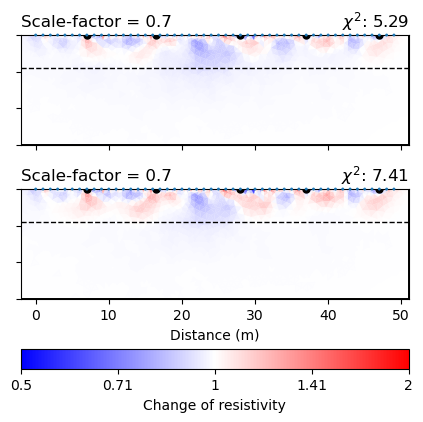

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5,6))
plt.subplots_adjust(hspace=-0.5)
for nr, chi2, m, name in zip([0,1],[chi2_oT, chi2_wT], [mod, mod_Tcorr], ['withoutTcorr', 'withTcorr']):
    ratio = m[1] / m[0]
    bild2 = manager[0].showResult(model= ratio,coverage = manager[0].coverage(),
            cMin=1/2, cMax=2, cMap= 'bwr', ax= axs[nr], label = 'Change of resistivity', logScale= True)
    if nr < 1:
        cb = bild2[-1]
        cb.remove() 
        axs[nr].xaxis.set_ticklabels([])  # Unterdrückt die x-Achse Labels
    if nr == 1:
        axs[nr].set_xlabel('Distance (m)')
        
    axs[nr].yaxis.set_ticklabels([])  # Unterdrückt die y-Achse Labels
    axs[nr].set_title('$\chi^2$: '+ str(chi2[0]), loc = 'right')
    axs[nr].set_title('Scale-factor = '+ str(0.7), loc = 'left')
    tree_postions = [7, 16.5, 28, 37, 47]
    for x in tree_postions:
        axs[nr].plot(x, 0, '.', markersize=10, color='black')
    axs[nr].set_ylim(-15, 0)
    axs[nr].axhline(y=-4.5, color='k', linewidth = 1,linestyle='--')

fig.savefig('./Fig11/FTL_inversion.png' , bbox_inches = 'tight', dpi=300)